In [1]:
import polars as pl
import seaborn as sns
from eda import hypothesis
from eda.output import display_multiple_df
from matplotlib import pyplot as plt
from polars import selectors as cs

In [2]:
pl.Config.set_fmt_str_lengths(40)

polars.config.Config

In [3]:
df = pl.read_parquet("data/credit-modeling.parquet")
print(df.shape)
df.head()

(51336, 87)


PROSPECTID,Total_TL,Tot_Closed_TL,Tot_Active_TL,Total_TL_opened_L6M,Tot_TL_closed_L6M,pct_tl_open_L6M,pct_tl_closed_L6M,pct_active_tl,pct_closed_tl,Total_TL_opened_L12M,Tot_TL_closed_L12M,pct_tl_open_L12M,pct_tl_closed_L12M,Tot_Missed_Pmnt,Auto_TL,CC_TL,Consumer_TL,Gold_TL,Home_TL,PL_TL,Secured_TL,Unsecured_TL,Other_TL,Age_Oldest_TL,Age_Newest_TL,time_since_recent_payment,time_since_first_deliquency,time_since_recent_deliquency,num_times_delinquent,max_delinquency_level,max_recent_level_of_deliq,num_deliq_6mts,num_deliq_12mts,num_deliq_6_12mts,max_deliq_6mts,max_deliq_12mts,…,num_lss_12mts,recent_level_of_deliq,tot_enq,CC_enq,CC_enq_L6m,CC_enq_L12m,PL_enq,PL_enq_L6m,PL_enq_L12m,time_since_recent_enq,enq_L12m,enq_L6m,enq_L3m,MARITALSTATUS,EDUCATION,AGE,GENDER,NETMONTHLYINCOME,Time_With_Curr_Empr,pct_of_active_TLs_ever,pct_opened_TLs_L6m_of_L12m,pct_currentBal_all_TL,CC_utilization,CC_Flag,PL_utilization,PL_Flag,pct_PL_enq_L6m_of_L12m,pct_CC_enq_L6m_of_L12m,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,max_unsec_exposure_inPct,HL_Flag,GL_Flag,last_prod_enq2,first_prod_enq2,Credit_Score,Approved_Flag
i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64,str,i64,i64,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str
1,5,4,1,0,0,0.0,0.0,0.2,0.8,0,0,0.0,0.0,0,0,0,0,1,0,4,1,4,0,72,18,549,35,15,11,29,29,0,0,0,-99999,-99999,…,0,29,6,0,0,0,6,0,0,566,0,0,0,"""Married""","""12TH""",48,"""M""",51000,114,0.2,0.0,0.798,-99999.0,0,0.798,1,0.0,0.0,0.0,0.0,13.333,1,0,"""PL""","""PL""",696,"""P2"""
2,1,0,1,0,0,0.0,0.0,1.0,0.0,1,0,1.0,0.0,0,0,0,1,0,0,0,0,1,0,7,7,47,-99999,-99999,0,-99999,0,0,0,0,0,0,…,0,0,1,0,0,0,0,0,0,209,1,0,0,"""Single""","""GRADUATE""",23,"""F""",19000,50,1.0,0.0,0.37,-99999.0,0,-99999.0,0,0.0,0.0,0.0,0.0,0.86,0,0,"""ConsumerLoan""","""ConsumerLoan""",685,"""P2"""
3,8,0,8,1,0,0.125,0.0,1.0,0.0,2,0,0.25,0.0,1,1,0,6,1,0,0,2,6,0,47,2,302,11,3,9,25,25,1,9,8,25,25,…,0,25,4,0,0,0,0,0,0,587,0,0,0,"""Married""","""SSC""",40,"""M""",18,191,1.0,0.5,0.585,-99999.0,0,-99999.0,0,0.0,0.0,0.0,0.0,5741.667,1,0,"""ConsumerLoan""","""others""",693,"""P2"""
4,1,0,1,1,0,1.0,0.0,1.0,0.0,1,0,1.0,0.0,1,0,0,0,0,0,0,0,1,1,5,5,-99999,-99999,-99999,0,-99999,0,0,0,0,-99999,-99999,…,0,0,-99999,-99999,-99999,-99999,-99999,-99999,-99999,-99999,-99999,-99999,-99999,"""Married""","""SSC""",34,"""M""",10000,246,1.0,1.0,0.99,-99999.0,0,-99999.0,0,0.0,0.0,0.0,0.0,9.9,0,0,"""others""","""others""",673,"""P2"""
5,3,2,1,0,0,0.0,0.0,0.333,0.667,0,0,0.0,0.0,0,1,0,0,0,0,0,3,0,2,131,32,583,-99999,-99999,0,-99999,0,0,0,0,-99999,-99999,…,0,0,1,0,0,0,0,0,0,3951,0,0,0,"""Married""","""POST-GRADUATE""",48,"""M""",15000,75,0.333,0.0,0.0,-99999.0,0,-99999.0,0,0.0,0.0,0.0,0.0,-99999.0,0,0,"""AL""","""AL""",753,"""P1"""


## Infer null values

In [4]:
df = df.with_columns(pl.all().replace(-99999, None))

In [5]:
# segregate cols of dataset
target_col = "Approved_Flag"
cat_cols = df.select(cs.string().exclude(target_col)).columns
num_cols = df.select(cs.numeric().exclude(target_col, "PROSPECTID")).columns

print(f"{target_col = }", end="\n\n")
print(f"{len(cat_cols)} {cat_cols = }", end="\n\n")
print(f"{len(num_cols)} {num_cols = }", end="\n\n")

target_col = 'Approved_Flag'

5 cat_cols = ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']

80 num_cols = ['Total_TL', 'Tot_Closed_TL', 'Tot_Active_TL', 'Total_TL_opened_L6M', 'Tot_TL_closed_L6M', 'pct_tl_open_L6M', 'pct_tl_closed_L6M', 'pct_active_tl', 'pct_closed_tl', 'Total_TL_opened_L12M', 'Tot_TL_closed_L12M', 'pct_tl_open_L12M', 'pct_tl_closed_L12M', 'Tot_Missed_Pmnt', 'Auto_TL', 'CC_TL', 'Consumer_TL', 'Gold_TL', 'Home_TL', 'PL_TL', 'Secured_TL', 'Unsecured_TL', 'Other_TL', 'Age_Oldest_TL', 'Age_Newest_TL', 'time_since_recent_payment', 'time_since_first_deliquency', 'time_since_recent_deliquency', 'num_times_delinquent', 'max_delinquency_level', 'max_recent_level_of_deliq', 'num_deliq_6mts', 'num_deliq_12mts', 'num_deliq_6_12mts', 'max_deliq_6mts', 'max_deliq_12mts', 'num_times_30p_dpd', 'num_times_60p_dpd', 'num_std', 'num_std_6mts', 'num_std_12mts', 'num_sub', 'num_sub_6mts', 'num_sub_12mts', 'num_dbt', 'num_dbt_6mts', 'num_dbt_12mts', 'num_lss', 

In [6]:
# Even more column datatype segregation
(
    df.select(
        pl.col(num_cols).n_unique(),
    )
    .transpose(include_header=True, column_names=["n_unique"])
    .filter(
        pl.col("n_unique").le(10),
    )
)

column,n_unique
str,u32
"""Home_TL""",9
"""num_sub_6mts""",7
"""num_dbt_6mts""",6
"""num_lss_6mts""",7
"""CC_Flag""",2
"""PL_Flag""",2
"""HL_Flag""",2
"""GL_Flag""",2


In [7]:
for i in df.select(cs.matches("*_Flag").exclude(target_col)).iter_columns():
    print(i.name, i.unique().to_list())

CC_Flag [0, 1]
PL_Flag [0, 1]
HL_Flag [0, 1]
GL_Flag [0, 1]


In [8]:
for i in df.select(cs.matches(r"num_\w+_6mts")).iter_columns():
    print(i.name, i.unique().to_list())

num_deliq_6mts [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
num_std_6mts [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 49, 52, 58, 60]
num_sub_6mts [0, 1, 2, 3, 4, 5, 8]
num_dbt_6mts [0, 2, 3, 4, 5, 6]
num_lss_6mts [0, 1, 2, 3, 4, 5, 12]


**CONCLUSION**

We can consider the `*_Flag` columns as categorical columns but not those `num_\w+_6mts` because
they doesn't represent a categorical they are number of _something_ (in banking) which can
increase more than that as we can see in `num_std_6mts` column.

In [9]:
# So we'll add those `*_Flag` columns in `cat_cols` list
cat_cols.extend(["CC_Flag", "PL_Flag", "HL_Flag", "GL_Flag"])
[num_cols.remove(col) for col in ["CC_Flag", "PL_Flag", "HL_Flag", "GL_Flag"]]

print(f"{len(cat_cols)} {cat_cols = }", end="\n\n")
print(f"{len(num_cols)} {num_cols = }", end="\n\n")

9 cat_cols = ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2', 'CC_Flag', 'PL_Flag', 'HL_Flag', 'GL_Flag']

76 num_cols = ['Total_TL', 'Tot_Closed_TL', 'Tot_Active_TL', 'Total_TL_opened_L6M', 'Tot_TL_closed_L6M', 'pct_tl_open_L6M', 'pct_tl_closed_L6M', 'pct_active_tl', 'pct_closed_tl', 'Total_TL_opened_L12M', 'Tot_TL_closed_L12M', 'pct_tl_open_L12M', 'pct_tl_closed_L12M', 'Tot_Missed_Pmnt', 'Auto_TL', 'CC_TL', 'Consumer_TL', 'Gold_TL', 'Home_TL', 'PL_TL', 'Secured_TL', 'Unsecured_TL', 'Other_TL', 'Age_Oldest_TL', 'Age_Newest_TL', 'time_since_recent_payment', 'time_since_first_deliquency', 'time_since_recent_deliquency', 'num_times_delinquent', 'max_delinquency_level', 'max_recent_level_of_deliq', 'num_deliq_6mts', 'num_deliq_12mts', 'num_deliq_6_12mts', 'max_deliq_6mts', 'max_deliq_12mts', 'num_times_30p_dpd', 'num_times_60p_dpd', 'num_std', 'num_std_6mts', 'num_std_12mts', 'num_sub', 'num_sub_6mts', 'num_sub_12mts', 'num_dbt', 'num_dbt_6mts', 'num_dbt_12mts

### Discrete Numerical Columns

In [10]:
float_cols = df.select(cs.float()).columns
int_cols = df.select(cs.integer()).columns

print(f"{len(float_cols)} {float_cols = }", end="\n\n")
print(f"{len(int_cols)} {int_cols = }", end="\n\n")

16 float_cols = ['pct_tl_open_L6M', 'pct_tl_closed_L6M', 'pct_active_tl', 'pct_closed_tl', 'pct_tl_open_L12M', 'pct_tl_closed_L12M', 'pct_of_active_TLs_ever', 'pct_opened_TLs_L6m_of_L12m', 'pct_currentBal_all_TL', 'CC_utilization', 'PL_utilization', 'pct_PL_enq_L6m_of_L12m', 'pct_CC_enq_L6m_of_L12m', 'pct_PL_enq_L6m_of_ever', 'pct_CC_enq_L6m_of_ever', 'max_unsec_exposure_inPct']

65 int_cols = ['PROSPECTID', 'Total_TL', 'Tot_Closed_TL', 'Tot_Active_TL', 'Total_TL_opened_L6M', 'Tot_TL_closed_L6M', 'Total_TL_opened_L12M', 'Tot_TL_closed_L12M', 'Tot_Missed_Pmnt', 'Auto_TL', 'CC_TL', 'Consumer_TL', 'Gold_TL', 'Home_TL', 'PL_TL', 'Secured_TL', 'Unsecured_TL', 'Other_TL', 'Age_Oldest_TL', 'Age_Newest_TL', 'time_since_recent_payment', 'time_since_first_deliquency', 'time_since_recent_deliquency', 'num_times_delinquent', 'max_delinquency_level', 'max_recent_level_of_deliq', 'num_deliq_6mts', 'num_deliq_12mts', 'num_deliq_6_12mts', 'max_deliq_6mts', 'max_deliq_12mts', 'num_times_30p_dpd', 'num_

**CONCLUSION**

Now, these `num_cols` and `cat_cols` variable contains the only required datatype columns.
There is no column mismatch in between.

## Infer DataType

In [11]:
df = df.with_columns(
    [
        pl.when(pl.col(col).eq(0)).then(False).otherwise(True).alias(col)
        for col in ["CC_Flag", "PL_Flag", "HL_Flag", "GL_Flag"]
    ]
)
df.head()

PROSPECTID,Total_TL,Tot_Closed_TL,Tot_Active_TL,Total_TL_opened_L6M,Tot_TL_closed_L6M,pct_tl_open_L6M,pct_tl_closed_L6M,pct_active_tl,pct_closed_tl,Total_TL_opened_L12M,Tot_TL_closed_L12M,pct_tl_open_L12M,pct_tl_closed_L12M,Tot_Missed_Pmnt,Auto_TL,CC_TL,Consumer_TL,Gold_TL,Home_TL,PL_TL,Secured_TL,Unsecured_TL,Other_TL,Age_Oldest_TL,Age_Newest_TL,time_since_recent_payment,time_since_first_deliquency,time_since_recent_deliquency,num_times_delinquent,max_delinquency_level,max_recent_level_of_deliq,num_deliq_6mts,num_deliq_12mts,num_deliq_6_12mts,max_deliq_6mts,max_deliq_12mts,…,num_lss_12mts,recent_level_of_deliq,tot_enq,CC_enq,CC_enq_L6m,CC_enq_L12m,PL_enq,PL_enq_L6m,PL_enq_L12m,time_since_recent_enq,enq_L12m,enq_L6m,enq_L3m,MARITALSTATUS,EDUCATION,AGE,GENDER,NETMONTHLYINCOME,Time_With_Curr_Empr,pct_of_active_TLs_ever,pct_opened_TLs_L6m_of_L12m,pct_currentBal_all_TL,CC_utilization,CC_Flag,PL_utilization,PL_Flag,pct_PL_enq_L6m_of_L12m,pct_CC_enq_L6m_of_L12m,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,max_unsec_exposure_inPct,HL_Flag,GL_Flag,last_prod_enq2,first_prod_enq2,Credit_Score,Approved_Flag
i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64,str,i64,i64,f64,f64,f64,f64,bool,f64,bool,f64,f64,f64,f64,f64,bool,bool,str,str,i64,str
1,5,4,1,0,0,0.0,0.0,0.2,0.8,0,0,0.0,0.0,0,0,0,0,1,0,4,1,4,0,72,18,549,35,15,11,29,29,0,0,0,null,null,…,0,29,6,0,0,0,6,0,0,566,0,0,0,"""Married""","""12TH""",48,"""M""",51000,114,0.2,0.0,0.798,null,false,0.798,true,0.0,0.0,0.0,0.0,13.333,true,false,"""PL""","""PL""",696,"""P2"""
2,1,0,1,0,0,0.0,0.0,1.0,0.0,1,0,1.0,0.0,0,0,0,1,0,0,0,0,1,0,7,7,47,null,null,0,null,0,0,0,0,0,0,…,0,0,1,0,0,0,0,0,0,209,1,0,0,"""Single""","""GRADUATE""",23,"""F""",19000,50,1.0,0.0,0.37,null,false,null,false,0.0,0.0,0.0,0.0,0.86,false,false,"""ConsumerLoan""","""ConsumerLoan""",685,"""P2"""
3,8,0,8,1,0,0.125,0.0,1.0,0.0,2,0,0.25,0.0,1,1,0,6,1,0,0,2,6,0,47,2,302,11,3,9,25,25,1,9,8,25,25,…,0,25,4,0,0,0,0,0,0,587,0,0,0,"""Married""","""SSC""",40,"""M""",18,191,1.0,0.5,0.585,null,false,null,false,0.0,0.0,0.0,0.0,5741.667,true,false,"""ConsumerLoan""","""others""",693,"""P2"""
4,1,0,1,1,0,1.0,0.0,1.0,0.0,1,0,1.0,0.0,1,0,0,0,0,0,0,0,1,1,5,5,null,null,null,0,null,0,0,0,0,null,null,…,0,0,null,null,null,null,null,null,null,null,null,null,null,"""Married""","""SSC""",34,"""M""",10000,246,1.0,1.0,0.99,null,false,null,false,0.0,0.0,0.0,0.0,9.9,false,false,"""others""","""others""",673,"""P2"""
5,3,2,1,0,0,0.0,0.0,0.333,0.667,0,0,0.0,0.0,0,1,0,0,0,0,0,3,0,2,131,32,583,null,null,0,null,0,0,0,0,null,null,…,0,0,1,0,0,0,0,0,0,3951,0,0,0,"""Married""","""POST-GRADUATE""",48,"""M""",15000,75,0.333,0.0,0.0,null,false,null,false,0.0,0.0,0.0,0.0,null,false,false,"""AL""","""AL""",753,"""P1"""


# EDA

## Numerical Features

In [12]:
# Analyse columns with different metrics
(
    df.select(cs.float().skew())
    .insert_column(0, pl.Series("statistic", ["skew"]))
    .vstack(
        df.select(
            pl.col(col).filter(pl.col(col).ne(0)).skew()
            for col in df.select(cs.float()).columns
        ).insert_column(0, pl.Series("statistic", ["skew_wo_0"]))
    )
    .vstack(
        df.select(cs.float().kurtosis()).insert_column(
            0, pl.Series("statistic", ["kurtosis"])
        )
    )
    .vstack(
        df.select(
            pl.col(col).filter(pl.col(col).eq(0)).len().cast(pl.Float64)
            for col in df.select(cs.float()).columns
        ).insert_column(0, pl.Series("statistic", ["count_of_0"]))
    )
)

statistic,pct_tl_open_L6M,pct_tl_closed_L6M,pct_active_tl,pct_closed_tl,pct_tl_open_L12M,pct_tl_closed_L12M,pct_of_active_TLs_ever,pct_opened_TLs_L6m_of_L12m,pct_currentBal_all_TL,CC_utilization,PL_utilization,pct_PL_enq_L6m_of_L12m,pct_CC_enq_L6m_of_L12m,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,max_unsec_exposure_inPct
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""skew""",1.641027,2.973669,-0.223995,0.223995,0.472657,1.999682,-0.223995,0.831113,150.239536,49.882062,-1.321759,1.562926,3.501893,1.744277,3.849403,77.399971
"""skew_wo_0""",0.643148,1.322615,-0.354315,-0.065199,-0.022713,1.083526,-0.354315,-0.432409,131.800062,49.066023,-1.222227,-1.5548,-1.245438,-0.874147,-0.582339,76.597287
"""kurtosis""",1.615088,9.142481,-1.409334,-1.409334,-1.314894,3.463799,-1.409334,-1.016282,23713.261272,2831.474993,1.177145,0.569713,10.613631,1.27777,13.497961,7461.906649
"""count_of_0""",30574.0,38021.0,8519.0,18377.0,18092.0,31770.0,8519.0,30574.0,11819.0,572.0,178.0,40236.0,47401.0,40236.0,47401.0,581.0


### Skew

In [13]:
skew_df = df.select(pl.col(float_cols).skew()).transpose(
    include_header=True, column_names=["skew"]
)
skew_df

column,skew
str,f64
"""pct_tl_open_L6M""",1.641027
"""pct_tl_closed_L6M""",2.973669
"""pct_active_tl""",-0.223995
"""pct_closed_tl""",0.223995
"""pct_tl_open_L12M""",0.472657
…,…
"""pct_PL_enq_L6m_of_L12m""",1.562926
"""pct_CC_enq_L6m_of_L12m""",3.501893
"""pct_PL_enq_L6m_of_ever""",1.744277


In [14]:
# Right skewed features
skew_df.top_k(10, by="skew")

column,skew
str,f64
"""pct_currentBal_all_TL""",150.239536
"""max_unsec_exposure_inPct""",77.399971
"""CC_utilization""",49.882062
"""pct_CC_enq_L6m_of_ever""",3.849403
"""pct_CC_enq_L6m_of_L12m""",3.501893
"""pct_tl_closed_L6M""",2.973669
"""pct_tl_closed_L12M""",1.999682
"""pct_PL_enq_L6m_of_ever""",1.744277
"""pct_tl_open_L6M""",1.641027


Generally, skewness of 0 is prefered because **skew=0** represents the normal distribution.

> But here, skewness values goes beyond expectation.

**How to tackle Skewness?**

We can scale the features.

In [15]:
right_skewed_cols = skew_df.top_k(10, by="skew").get_column("column").to_list()
right_skewed_cols

['pct_currentBal_all_TL',
 'max_unsec_exposure_inPct',
 'CC_utilization',
 'pct_CC_enq_L6m_of_ever',
 'pct_CC_enq_L6m_of_L12m',
 'pct_tl_closed_L6M',
 'pct_tl_closed_L12M',
 'pct_PL_enq_L6m_of_ever',
 'pct_tl_open_L6M',
 'pct_PL_enq_L6m_of_L12m']

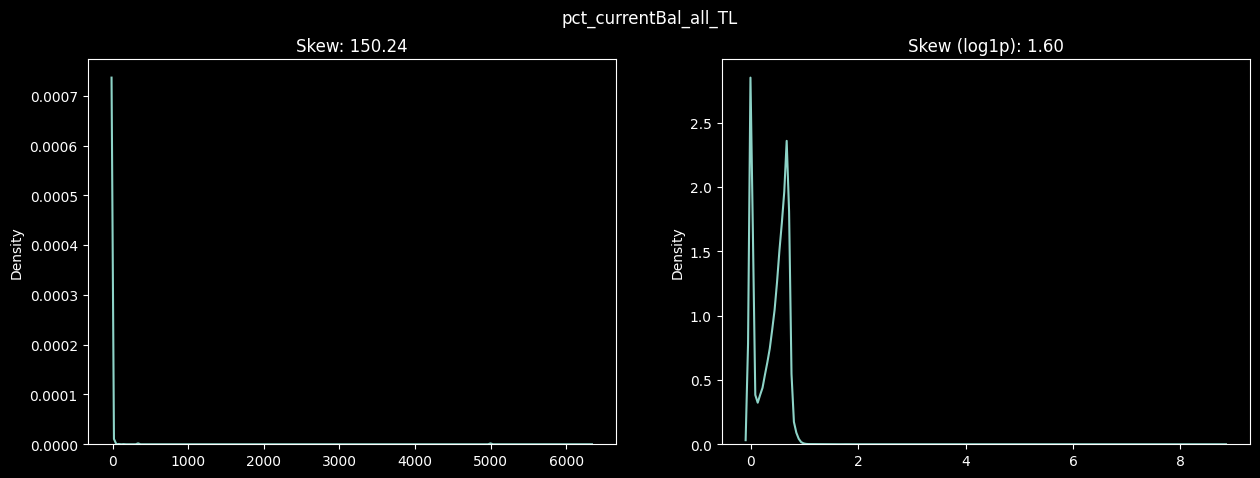

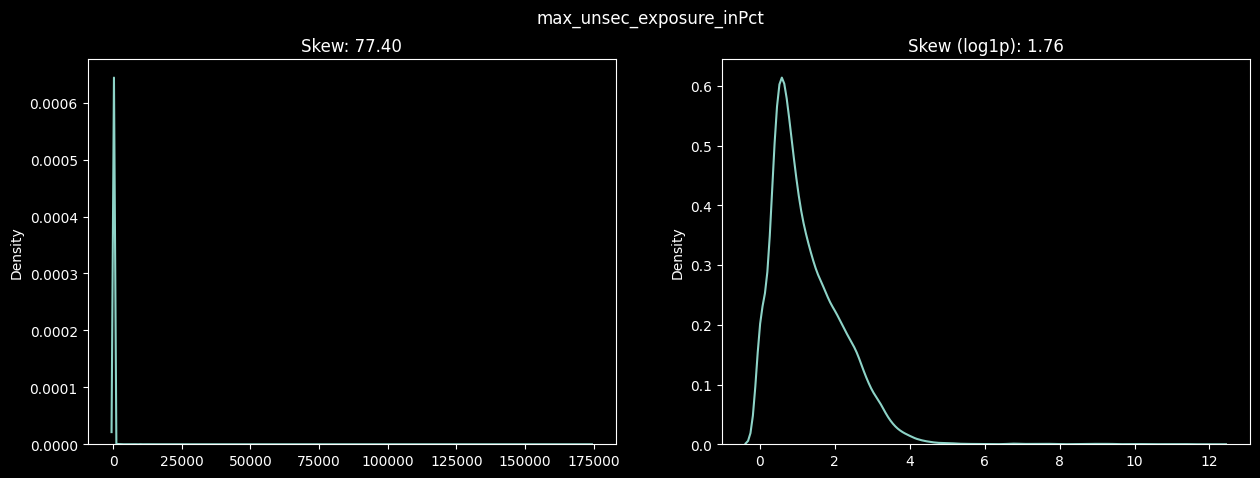

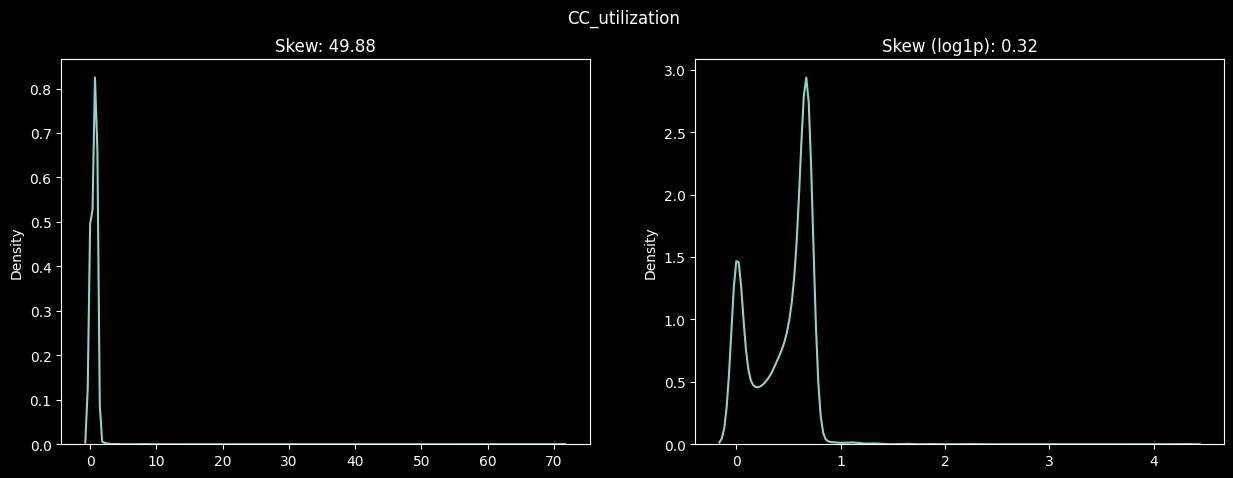

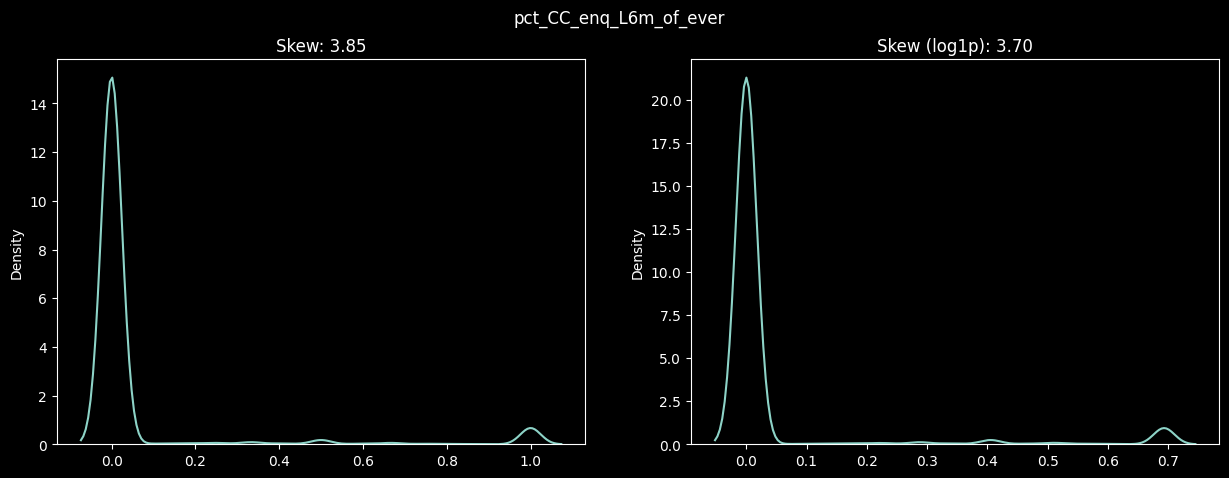

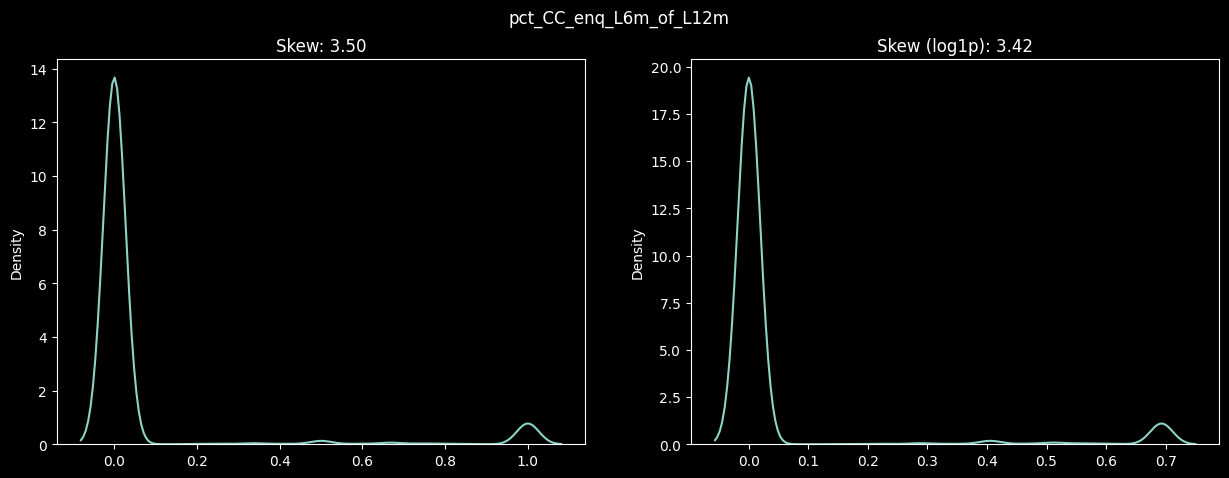

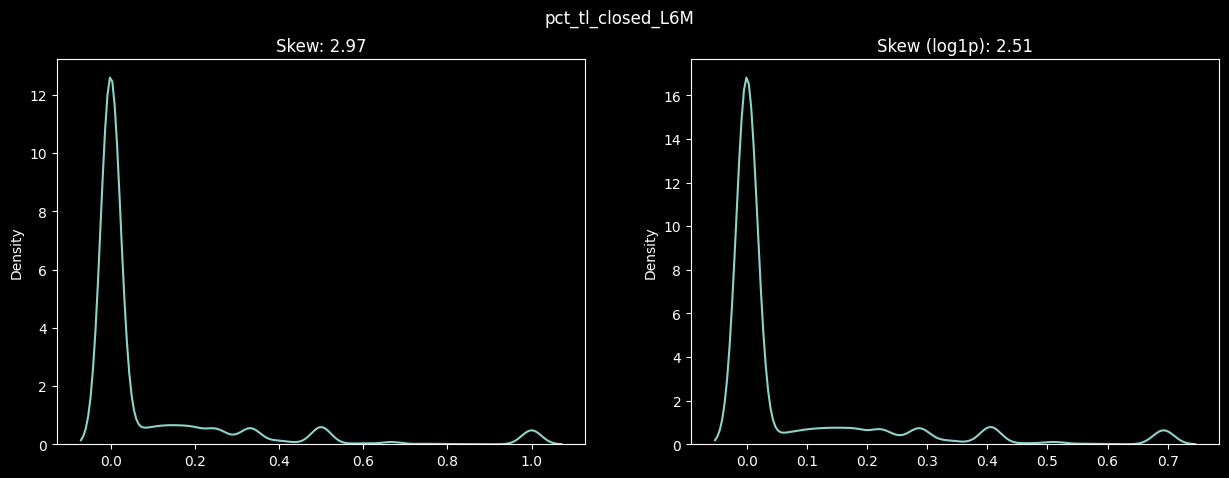

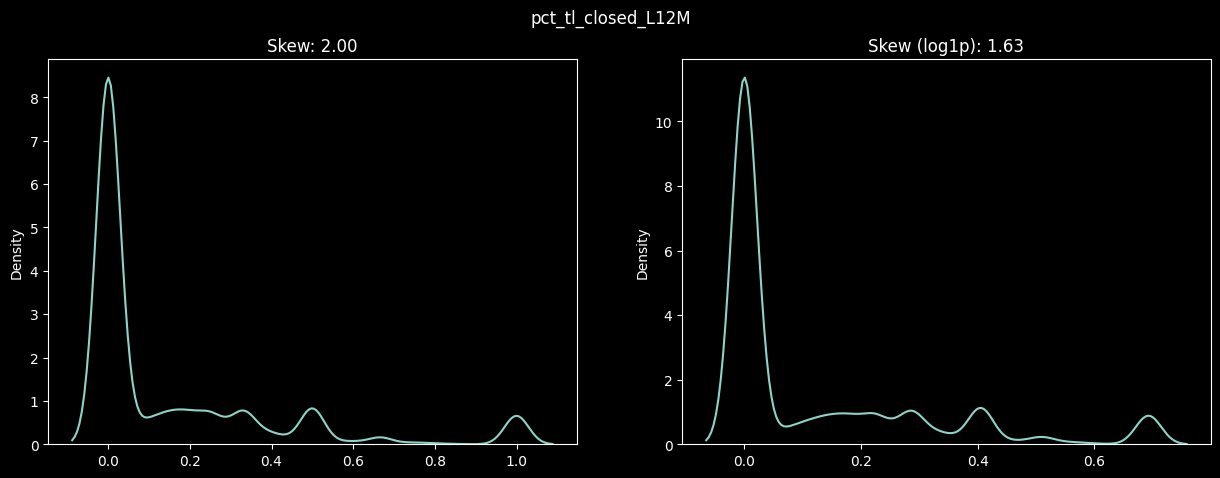

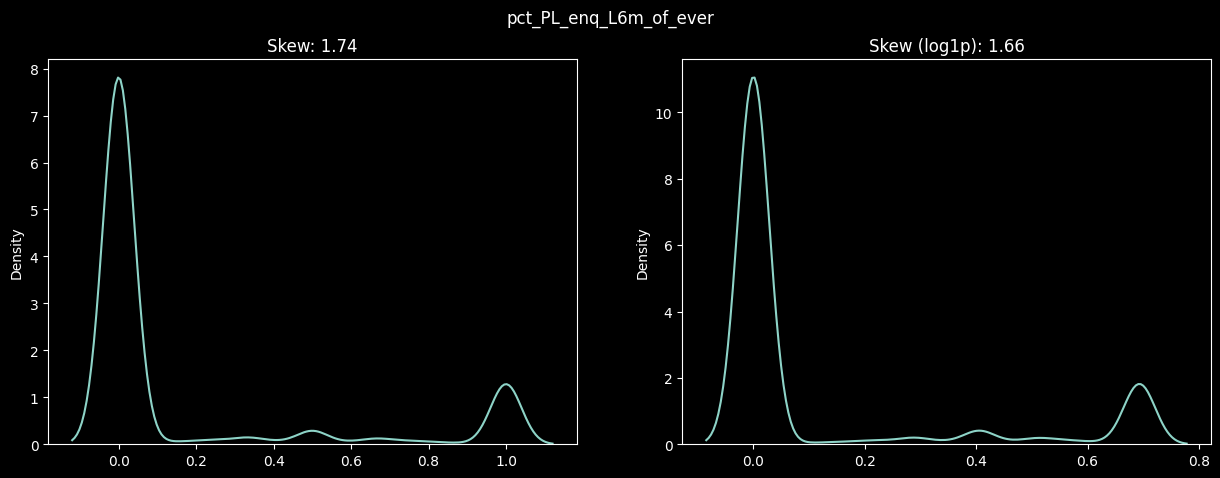

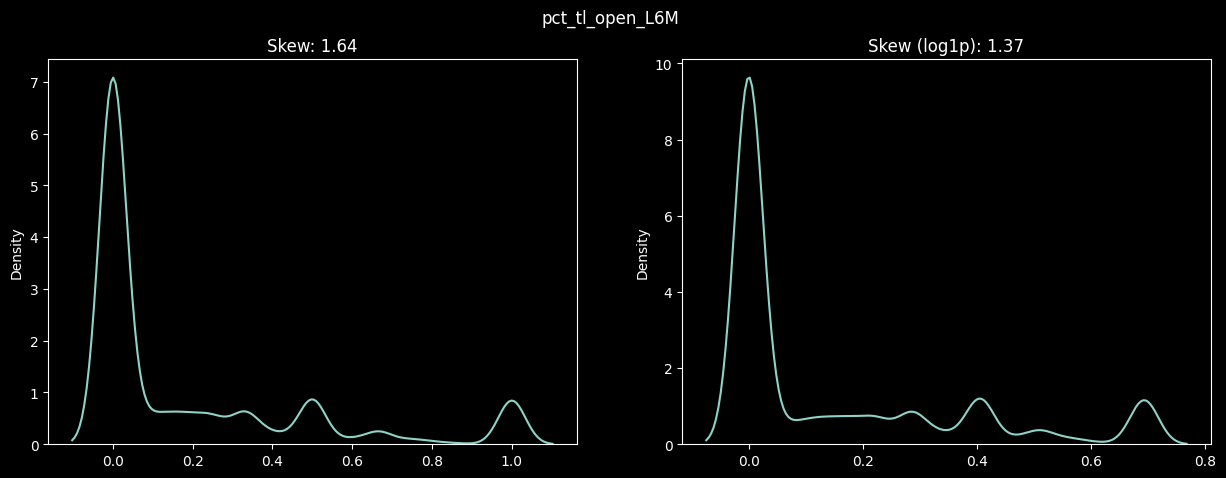

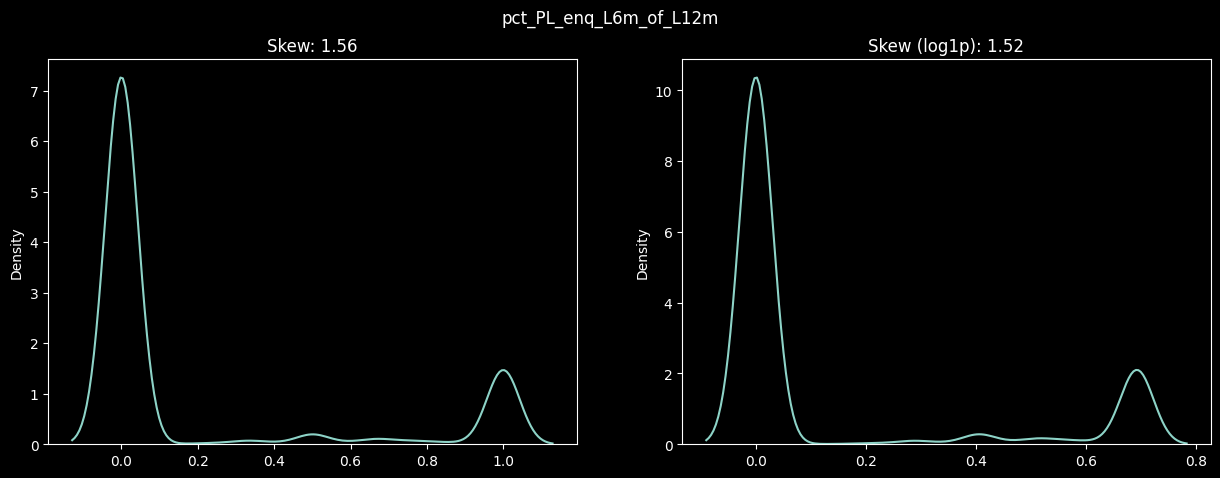

In [16]:
for col in right_skewed_cols:
    data = df.get_column(col)
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(col)

    plt.subplot(1, 2, 1)
    sns.kdeplot(data)
    plt.title(f"Skew: {data.skew():.2f}")

    plt.subplot(1, 2, 2)
    sns.kdeplot(data.log1p())
    plt.title(f"Skew (log1p): {data.log1p().skew():.2f}")

    plt.show()

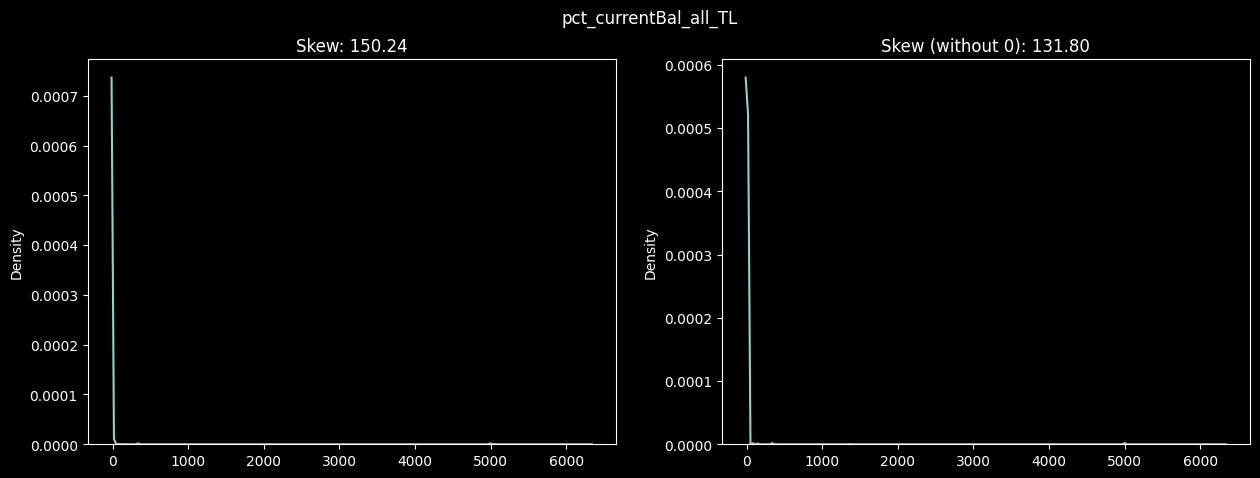

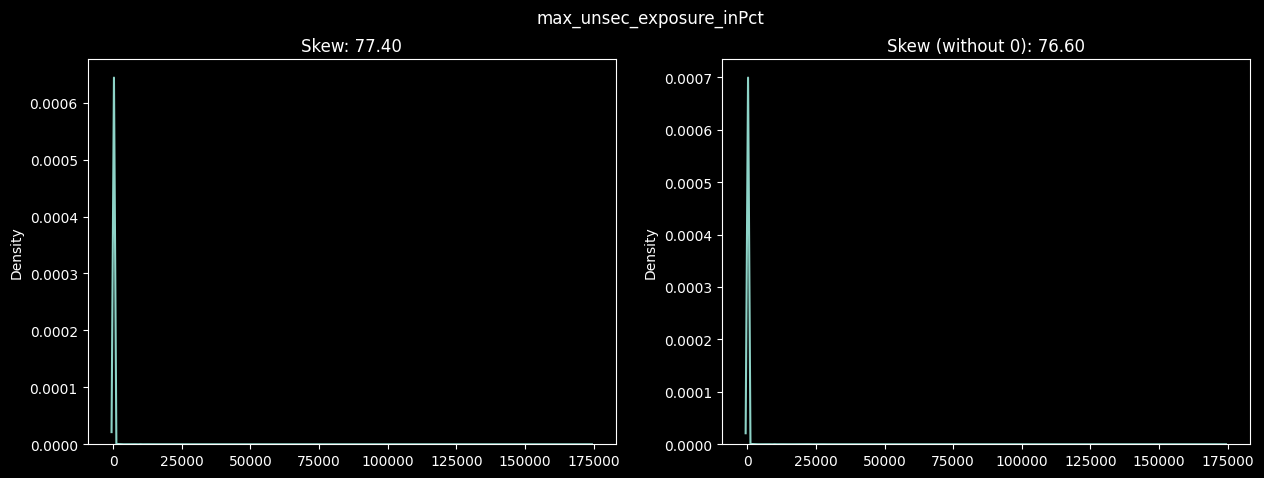

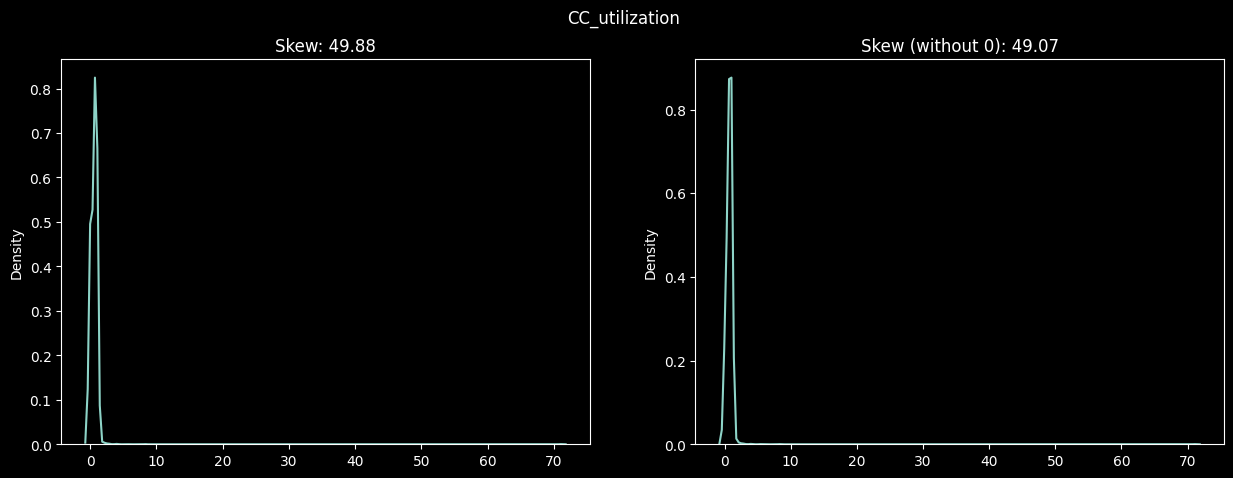

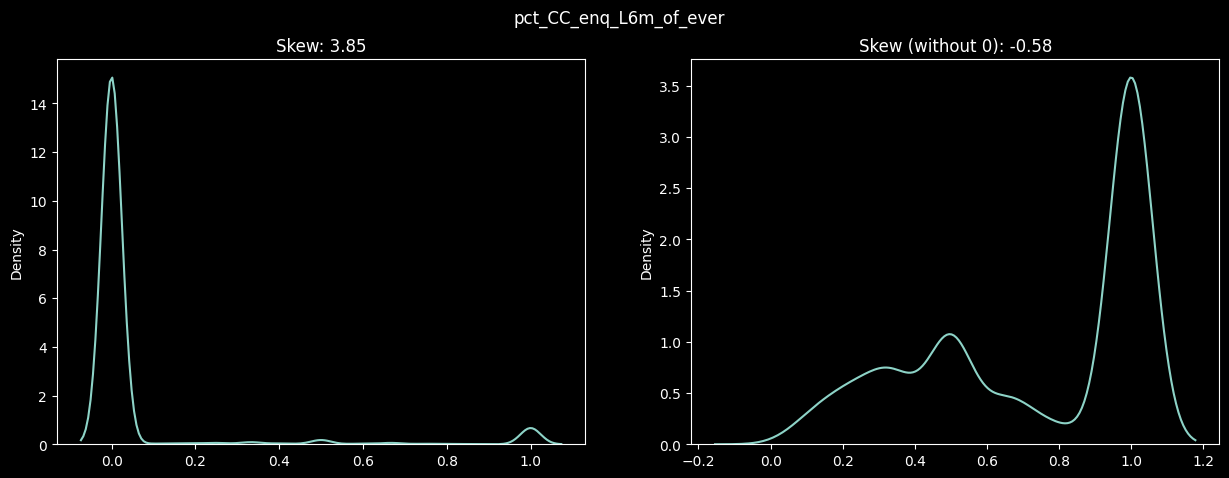

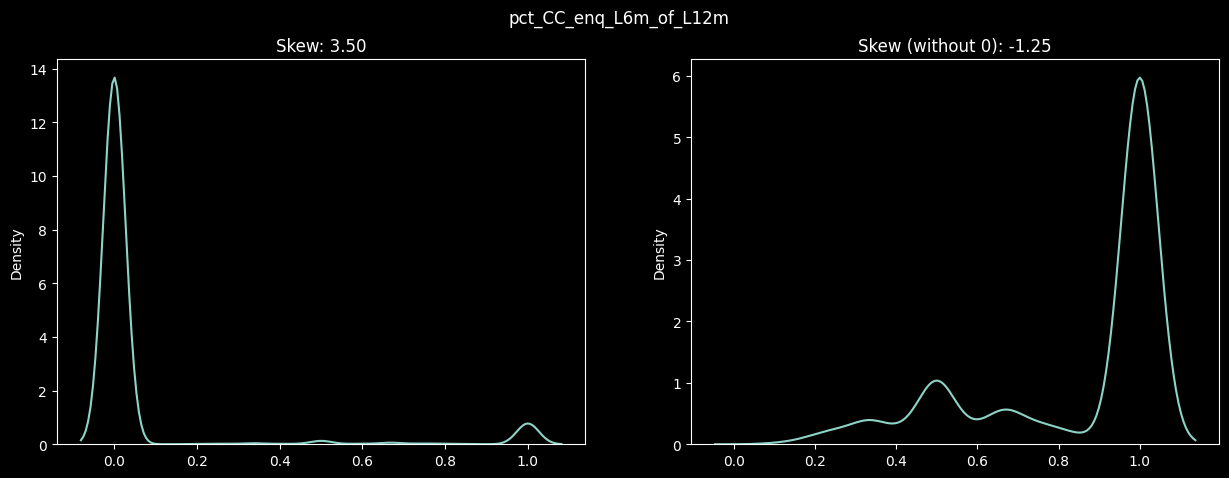

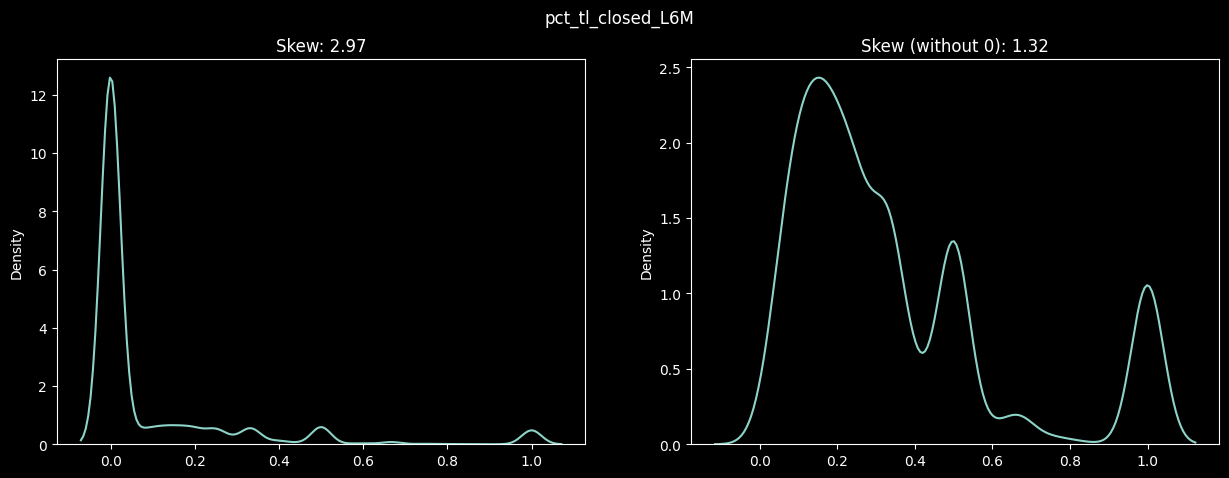

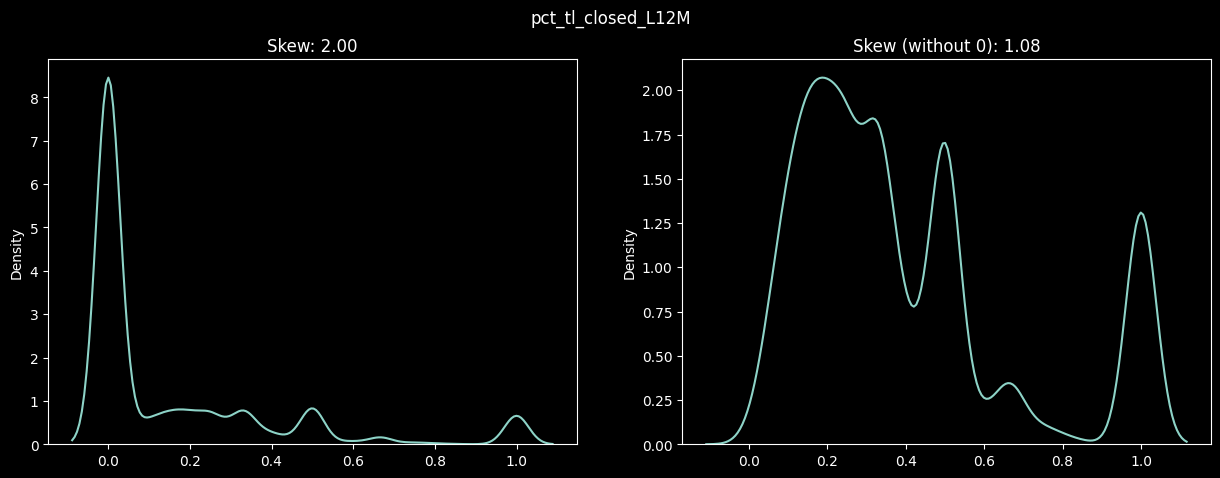

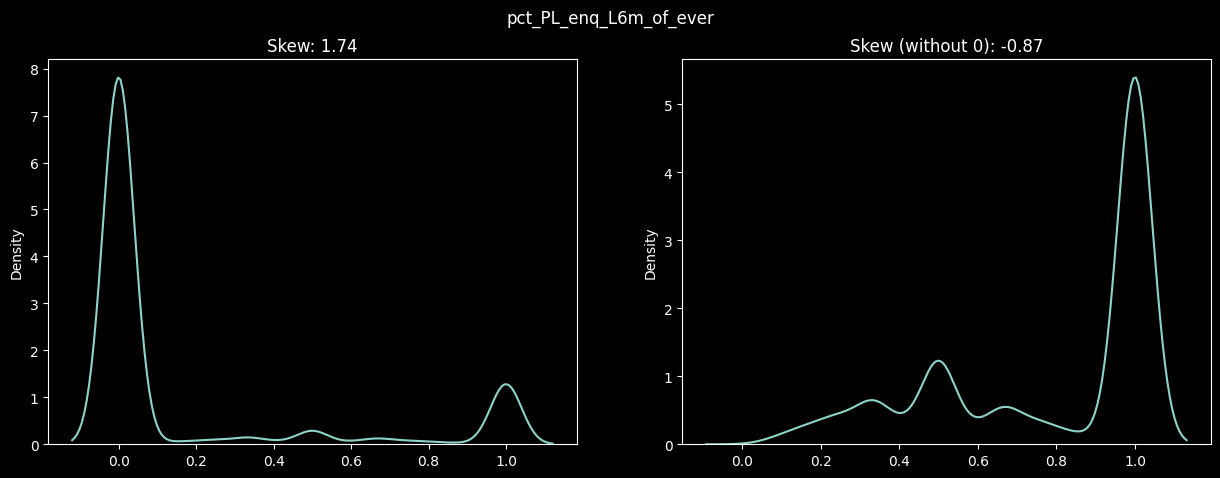

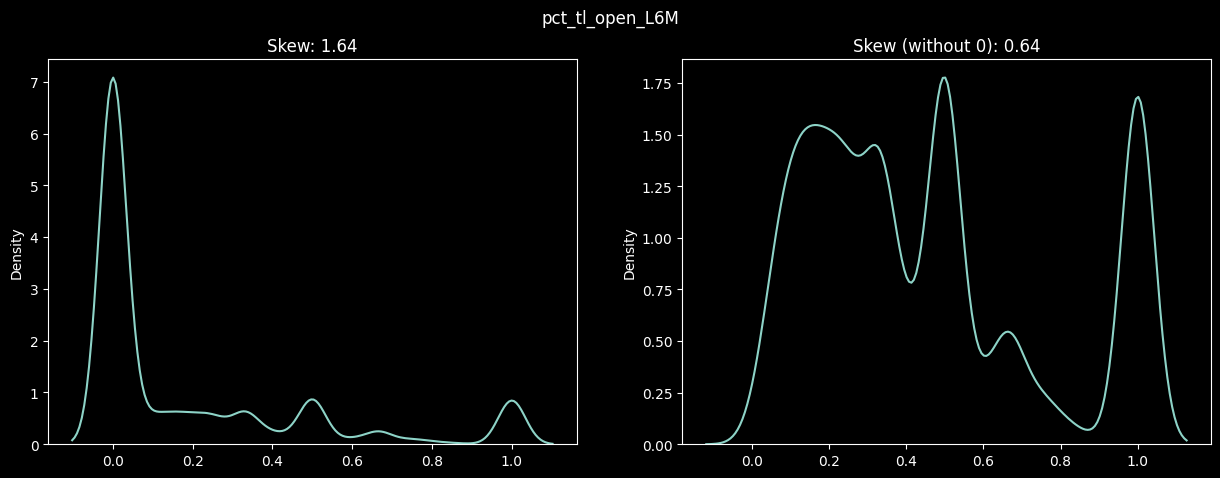

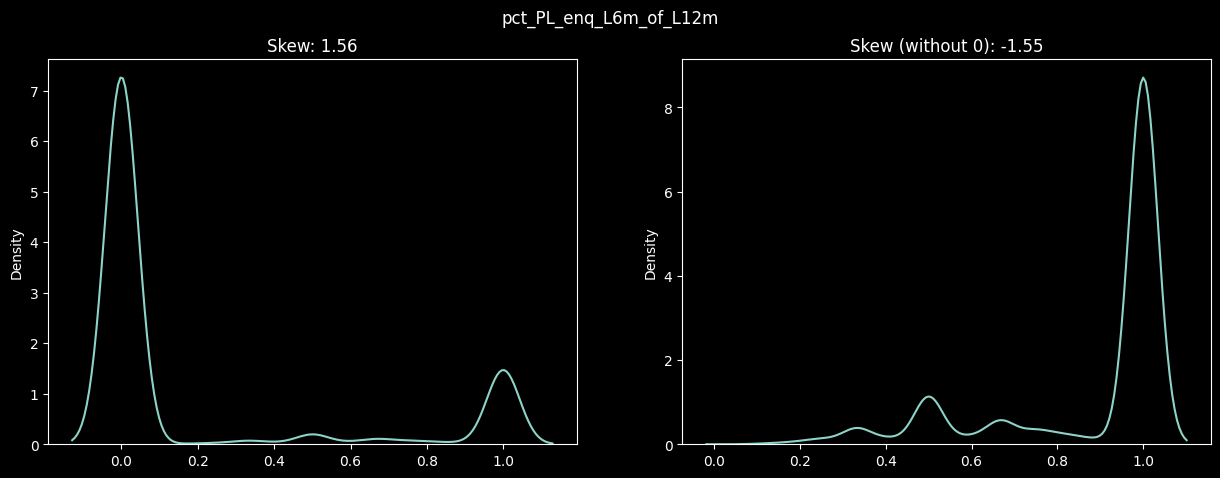

In [39]:
for col in right_skewed_cols:
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(col)

    data = df.get_column(col)
    plt.subplot(1, 2, 1)
    sns.kdeplot(data)
    plt.title(f"Skew: {data.skew():.2f}")

    data = df.get_column(col).filter(df.get_column(col).ne(0))
    plt.subplot(1, 2, 2)
    sns.kdeplot(data)
    plt.title(f"Skew (without 0): {data.skew():.2f}")

    plt.show()

In [ ]:
display_multiple_df(
    *[df.get_column(col).value_counts(sort=True) for col in right_skewed_cols]
)

In [40]:
df.select(right_skewed_cols).describe()

statistic,pct_currentBal_all_TL,max_unsec_exposure_inPct,CC_utilization,pct_CC_enq_L6m_of_ever,pct_CC_enq_L6m_of_L12m,pct_tl_closed_L6M,pct_tl_closed_L12M,pct_PL_enq_L6m_of_ever,pct_tl_open_L6M,pct_PL_enq_L6m_of_L12m
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",51264.0,28158.0,3700.0,51336.0,51336.0,51336.0,51336.0,51336.0,51336.0,51336.0
"""null_count""",72.0,23178.0,47636.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.836152,38.664235,0.628344,0.056302,0.065182,0.089095,0.149989,0.170492,0.184574,0.190414
"""std""",36.828156,1498.955157,1.237861,0.213506,0.235706,0.205635,0.257267,0.350209,0.297414,0.376218
"""min""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",0.087,0.775,0.187,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""50%""",0.618,1.82,0.739,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""75%""",0.889,5.283,0.964,0.0,0.0,0.053,0.25,0.0,0.308,0.0
"""max""",6327.5,173800.0,71.059,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**CONCLUSION**

- These `right_skewed_cols` (except some) features contains discrete values like 0, 1, 2, 3,... and
  has many-many `0` value (approx. 50k) which makes there skew value large.
- All `left_skewed_cols` has min=0.

We need to handle those `0` value in those feature.

In [41]:
# Left skewed features
skew_df.bottom_k(10, by="skew")

column,skew
str,f64
"""PL_utilization""",-1.321759
"""pct_of_active_TLs_ever""",-0.223995
"""pct_active_tl""",-0.223995
"""pct_closed_tl""",0.223995
"""pct_tl_open_L12M""",0.472657
"""pct_opened_TLs_L6m_of_L12m""",0.831113
"""pct_PL_enq_L6m_of_L12m""",1.562926
"""pct_tl_open_L6M""",1.641027
"""pct_PL_enq_L6m_of_ever""",1.744277


They are moderatly left skewed data.

In [42]:
left_skewed_cols = skew_df.bottom_k(10, by="skew").get_column("column").to_list()
left_skewed_cols

['PL_utilization',
 'pct_of_active_TLs_ever',
 'pct_active_tl',
 'pct_closed_tl',
 'pct_tl_open_L12M',
 'pct_opened_TLs_L6m_of_L12m',
 'pct_PL_enq_L6m_of_L12m',
 'pct_tl_open_L6M',
 'pct_PL_enq_L6m_of_ever',
 'pct_tl_closed_L12M']

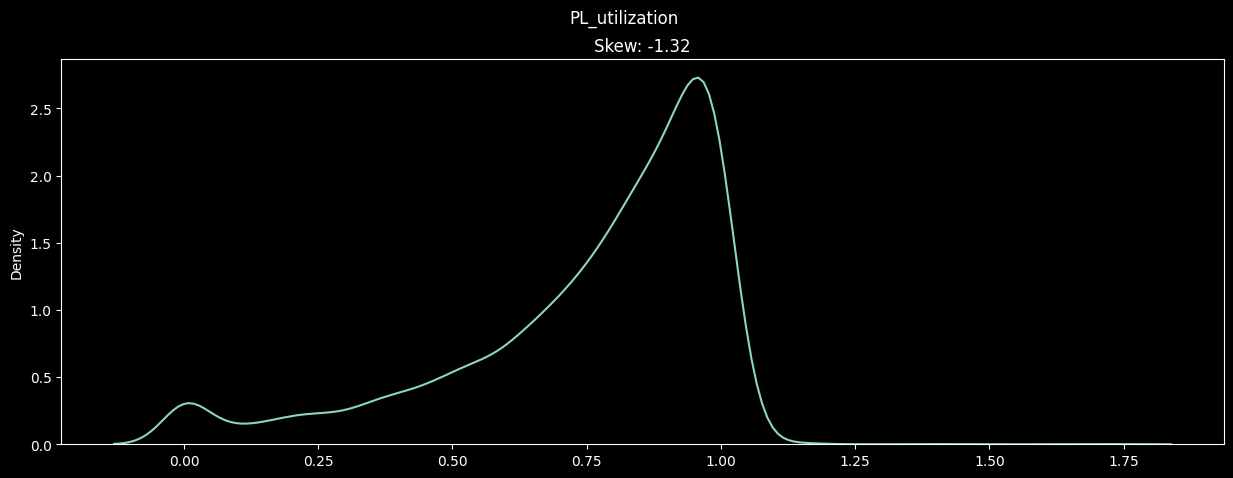

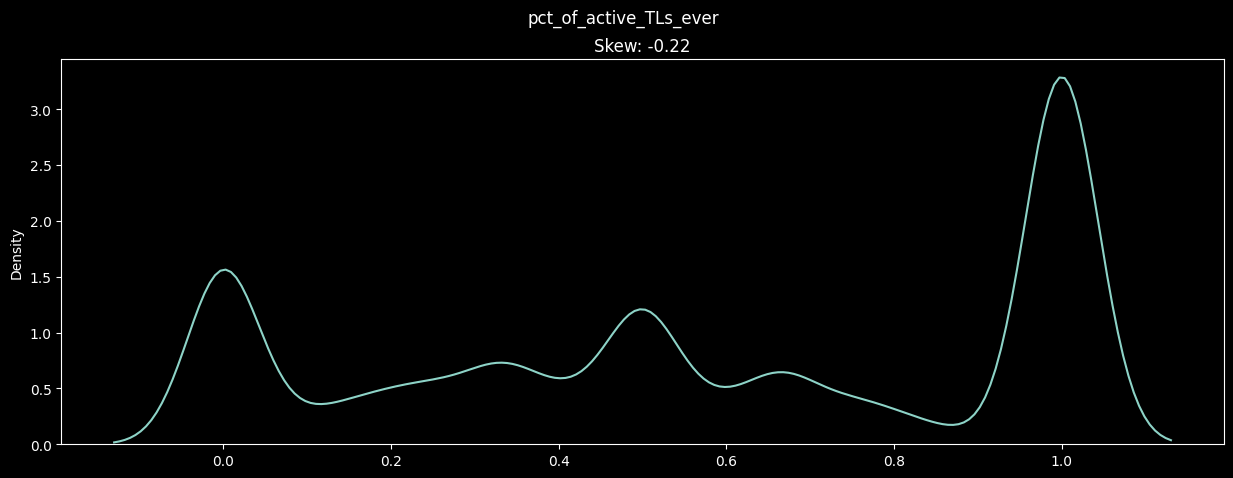

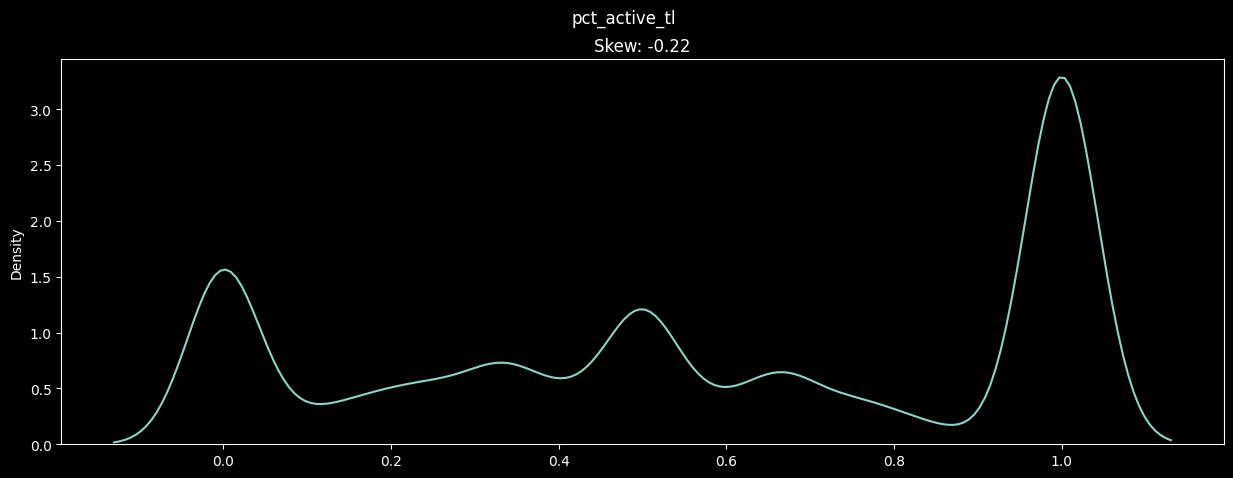

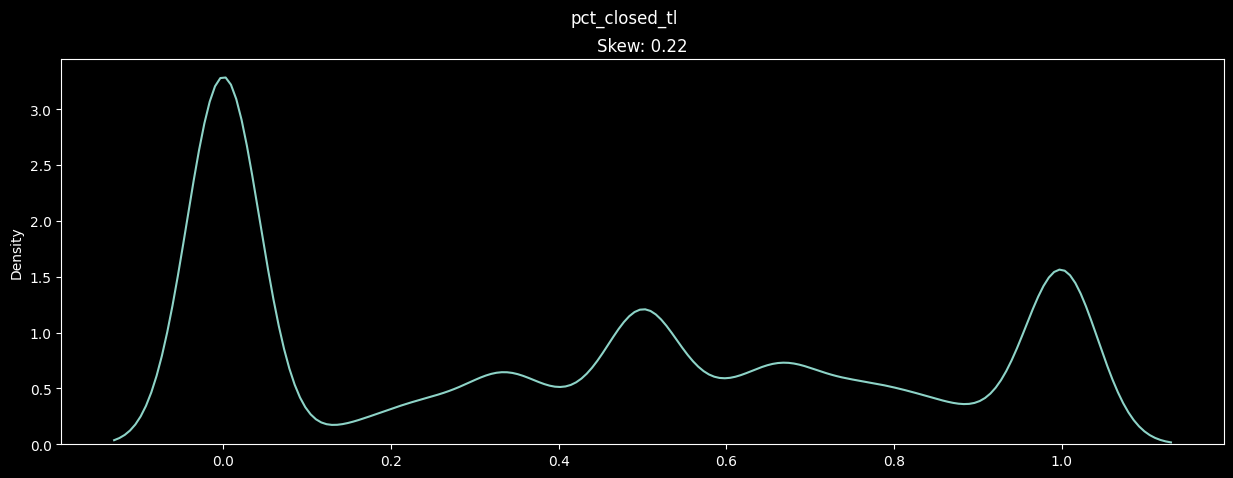

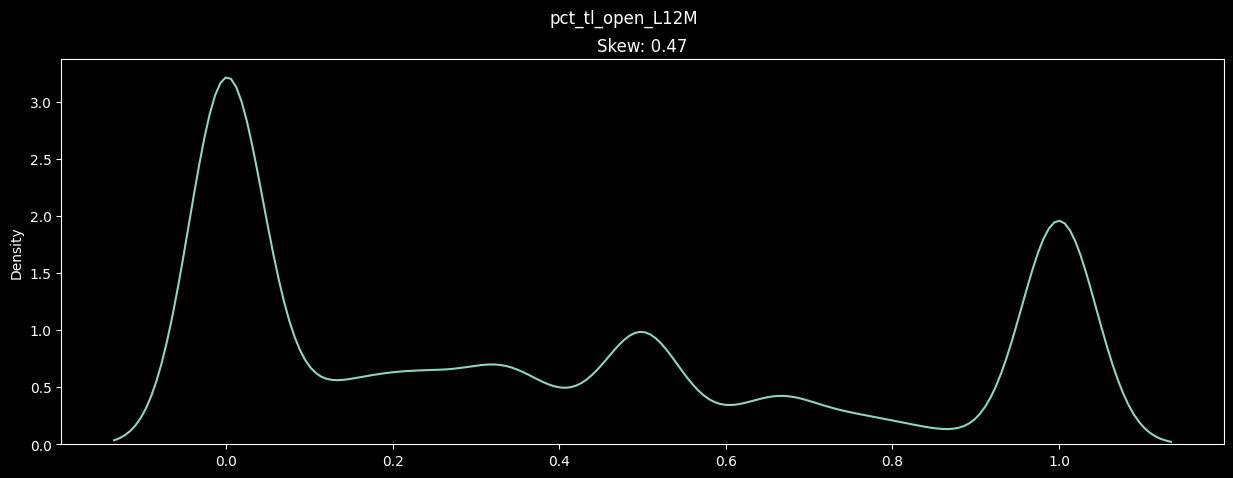

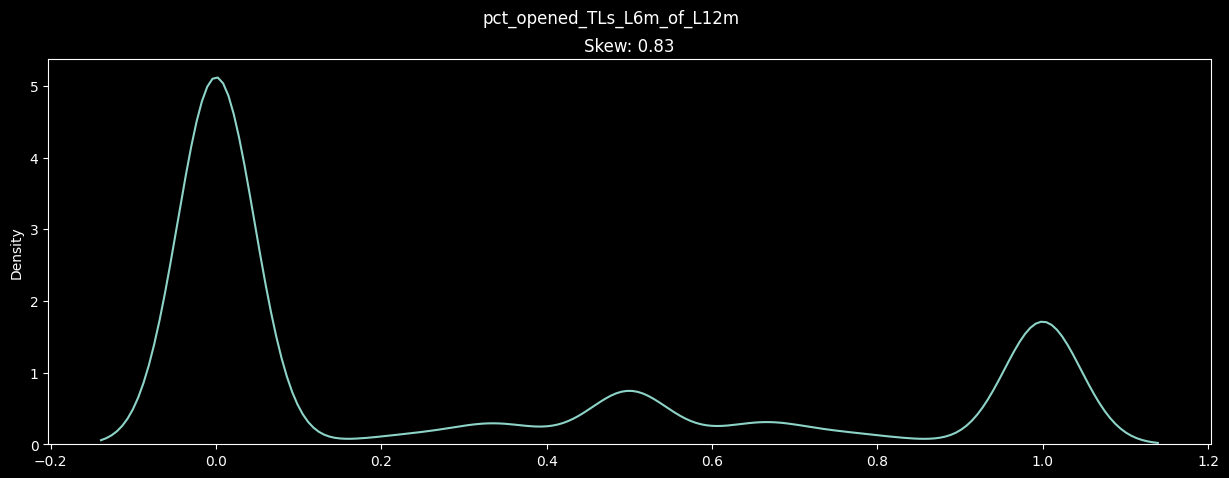

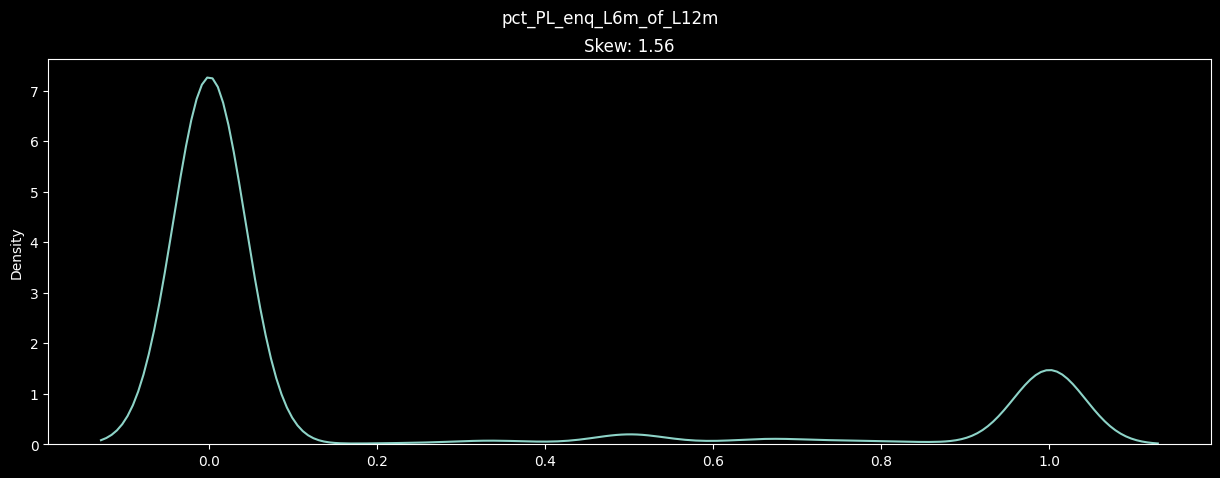

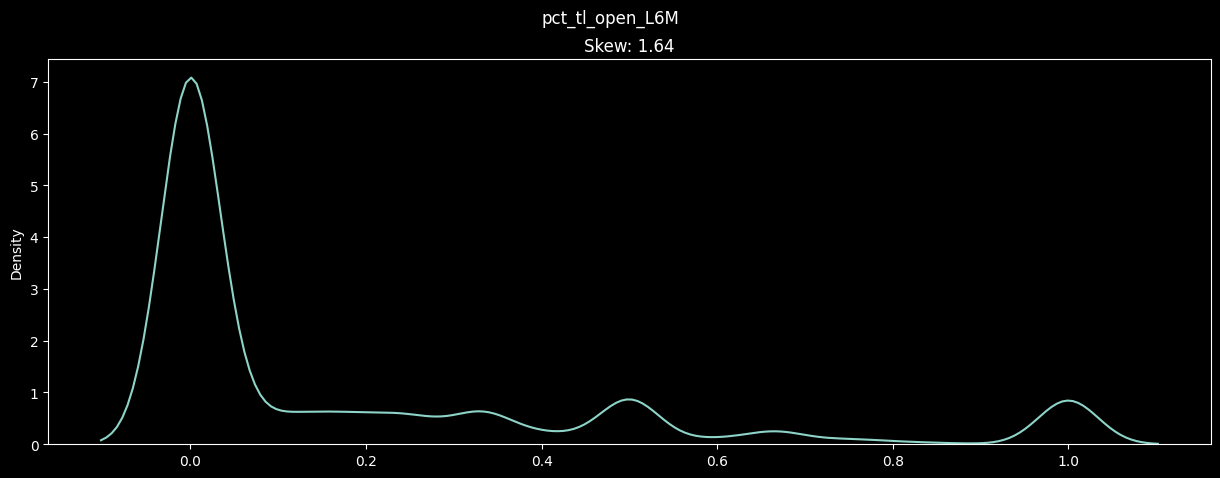

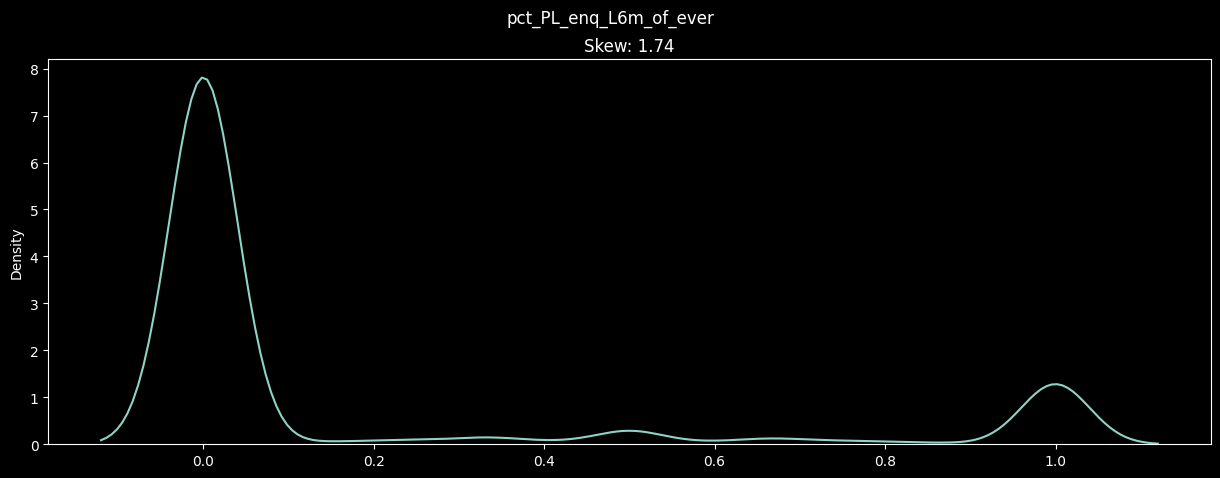

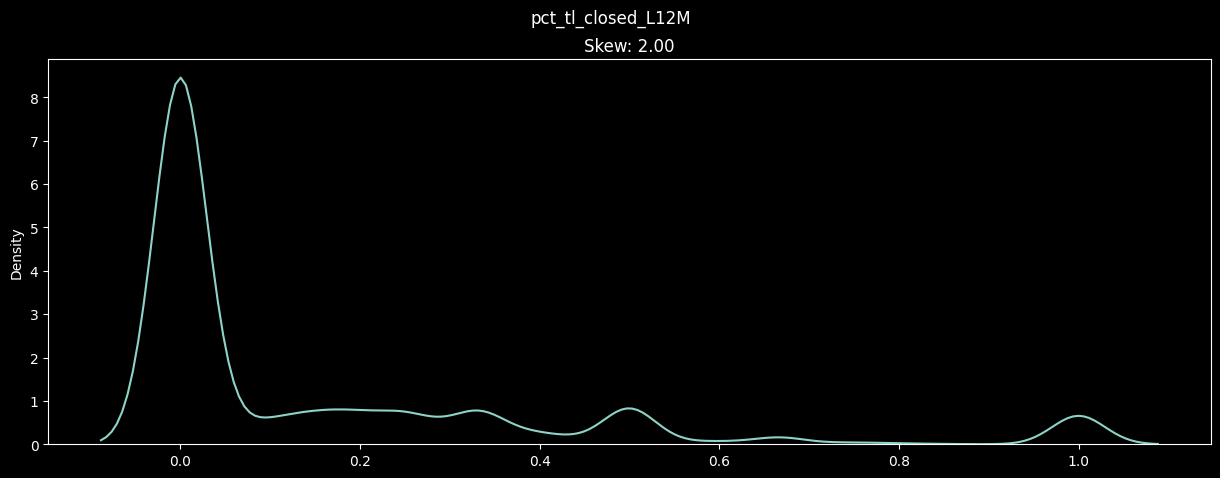

In [43]:
# Plot above features
for col in left_skewed_cols:
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(col)

    sns.kdeplot(df.get_column(col))
    plt.title(f"Skew: {df.get_column(col).skew():.2f}")

    plt.show()

In [ ]:
display_multiple_df(
    *[df.get_column(col).value_counts(sort=True) for col in left_skewed_cols]
)

In [ ]:
df.select(left_skewed_cols).describe()

In [54]:
df.select(pl.col(float_cols).eq(0).sum())

pct_tl_open_L6M,pct_tl_closed_L6M,pct_active_tl,pct_closed_tl,pct_tl_open_L12M,pct_tl_closed_L12M,pct_of_active_TLs_ever,pct_opened_TLs_L6m_of_L12m,pct_currentBal_all_TL,CC_utilization,PL_utilization,pct_PL_enq_L6m_of_L12m,pct_CC_enq_L6m_of_L12m,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,max_unsec_exposure_inPct
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
30574,38021,8519,18377,18092,31770,8519,30574,11819,572,178,40236,47401,40236,47401,581


**CONCLUSION**

- Every `left_skewed_cols` feature has null values.
- These `*12m`, `*6m`, `*3m` features have many `0` values which leads to high skewness.

**EXTRA**

- `time_since_recent_payment` feature 4.2k null values and has very high variance because
  75%tile=195 and max=6065.

## Hypothesis Testing

### Num VS Num

In [55]:
pl.DataFrame(
    [
        hypothesis.num_vs_num(df["Credit_Score"], df["Total_TL"], "kendalltau"),
        hypothesis.num_vs_num(df["Credit_Score"], df["Total_TL"], "pearsonr"),
        hypothesis.num_vs_num(df["Credit_Score"], df["Total_TL"], "spearmanr"),
    ]
)

p_value,statistic,hypothesis,reject_null_hypothesis
f64,f64,str,i64
0.0,0.147591,"""kendalltau""",1
0.0,0.202859,"""pearsonr""",1
0.0,0.203461,"""spearmanr""",1


In [58]:
df.select(pl.col(int_cols).eq(0).sum())

PROSPECTID,Total_TL,Tot_Closed_TL,Tot_Active_TL,Total_TL_opened_L6M,Tot_TL_closed_L6M,Total_TL_opened_L12M,Tot_TL_closed_L12M,Tot_Missed_Pmnt,Auto_TL,CC_TL,Consumer_TL,Gold_TL,Home_TL,PL_TL,Secured_TL,Unsecured_TL,Other_TL,Age_Oldest_TL,Age_Newest_TL,time_since_recent_payment,time_since_first_deliquency,time_since_recent_deliquency,num_times_delinquent,max_delinquency_level,max_recent_level_of_deliq,num_deliq_6mts,num_deliq_12mts,num_deliq_6_12mts,max_deliq_6mts,max_deliq_12mts,num_times_30p_dpd,num_times_60p_dpd,num_std,num_std_6mts,num_std_12mts,num_sub,num_sub_6mts,num_sub_12mts,num_dbt,num_dbt_6mts,num_dbt_12mts,num_lss,num_lss_6mts,num_lss_12mts,recent_level_of_deliq,tot_enq,CC_enq,CC_enq_L6m,CC_enq_L12m,PL_enq,PL_enq_L6m,PL_enq_L12m,time_since_recent_enq,enq_L12m,enq_L6m,enq_L3m,AGE,NETMONTHLYINCOME,Time_With_Curr_Empr,CC_Flag,PL_Flag,HL_Flag,GL_Flag,Credit_Score
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,18377,8519,30574,38021,18092,31770,34089,29328,46743,27873,37418,48621,42718,14360,17979,28901,21,155,0,28,83,35949,0,35949,46554,42908,45187,33664,32076,43345,46447,31655,37369,35636,50682,51285,51178,51166,51320,51296,51234,51324,51311,35949,0,37180,41080,39563,26084,33915,29953,427,9373,15669,21116,0,46,2,46743,42718,37418,48621,0


### Cat VS Num

In [62]:
group_by, col = "Total_TL", "Credit_Score"
groups = df.group_by(group_by).agg(col).get_column(col)
pl.DataFrame(
    [
        hypothesis.num_vs_cat(groups, "f_oneway"),
        hypothesis.num_vs_cat(groups, "kruskal"),
    ]
)

p_value,statistic,hypothesis,reject_null_hypothesis
f64,f64,str,i64
0.0,30.589033,"""f_oneway""",1
0.0,2396.772216,"""kruskal""",1


### Cat VS Cat

In [81]:
_dfs: list[tuple] = []

for col in cat_cols:
    cont_table = df.pivot(
        values=col, index="Approved_Flag", columns=col, aggregate_function="len"
    ).drop("Approved_Flag")
    _dfs.append((col, pl.DataFrame(hypothesis.cat_vs_cat(cont_table))))

display_multiple_df(*_dfs)

p_value,statistic,hypothesis,reject_null_hypothesis
f64,f64,str,bool
2.7588e-257,1188.129358,"""chi2_contingency""",true
p_value,statistic,hypothesis,reject_null_hypothesis
f64,f64,str,bool
8.4647e-38,225.246136,"""chi2_contingency""",true
p_value,statistic,hypothesis,reject_null_hypothesis
f64,f64,str,bool
0.000245,19.229726,"""chi2_contingency""",true
p_value,statistic,hypothesis,reject_null_hypothesis
f64,f64,str,bool
